In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 200
import datetime
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, date

old_data_folder = '/Users/simonneumeyer/Dropbox/DO-FILES/data/'



Bad key "text.kerning_factor" on line 4 in
/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# load data

In [17]:
#data = pd.read_parquet('../../data/output/loan_level.pq', engine='pyarrow')
df_master = pd.read_parquet('../../data/output/firm_year_level.pq', engine='pyarrow')
#df_master = pd.read_stata('../../data/output/firm_year_level.dta')
#df_master = pd.read_stata('../../data/firm_year_level.dta')
#prod_for_tfp = pd.read_stata(old_data_folder + "/Kosovo Tax Registry/productivity_for_tfp.dta")
#tax_data = pd.read_stata(old_data_folder + 'Kosovo Tax Registry/taxregistry_descriptive.dta')

# preprocess data

In [18]:
#df_master = df_master[df_master._merge != 'left_only']

In [19]:
#df_master[[x for x in df_master.columns if 'turnover' in x]]

In [20]:
#len(df_master[(df_master['credit']==1) & (df_master['kcgf']==0)])

In [21]:
#len(df_master[(df_master['credit']==0) & (df_master['kcgf']==0)])

In [22]:
#len(df_master[(df_master['credit']==0)])

In [23]:
def fund_identifier(row):
    if row.kcgf==1:
        return 1
    elif row.credit==1 and row.kcgf==0:
        return 0
    elif row.credit==0 and row.kcgf==0:
        return 2

df_master['kcgf'] = df_master.apply(fund_identifier, axis=1)

AttributeError: 'Series' object has no attribute 'kcgf'

In [ ]:
df_master['kcgf_label'] = df_master.kcgf.map({0: 'not funded by KCGF', 1: 'funded by KCGF', 2: 'no loan received'})

# get exit rates

In [13]:
int_cols = ['death_year', 'deaths']

deaths = df_master.groupby(['death_year', 'kcgf_label']).size().unstack(fill_value=0).stack().reset_index().rename(
    columns={0: 'deaths'})
deaths[int_cols] = deaths[int_cols].astype(int)
#deaths['death_time'] = deaths.apply(lambda row: date(year=row.death_year, month=1, day=1),
#                                    axis=1)
deaths = deaths.rename(columns={'death_year': 'period'})

KeyError: 'death_year'

In [12]:
total_firms = df_master.groupby(['period', 'kcgf_label']).size().reset_index().rename(
    columns={0: 'number_of_firms'})

KeyError: 'kcgf_label'

In [13]:
death_rates = deaths.merge(total_firms, how='left', on=['period', 'kcgf_label'], validate='m:1')

NameError: name 'deaths' is not defined

In [14]:
death_rates['death_rates'] = death_rates.deaths / death_rates.number_of_firms

NameError: name 'death_rates' is not defined

In [15]:
death_rates = death_rates[death_rates.period<2019]

NameError: name 'death_rates' is not defined

In [16]:
#death_rates

In [17]:
#entries = df_master.groupby(['birthyear_tx', 'participation_label']).size().reset_index().rename(
#    columns={0: 'entries'})
#entries[['birthyear_tx', 'entries']] = entries[['birthyear_tx', 'entries']].astype(int)
#
#
#entries = entries.rename(columns={'birthyear_tx': 'period'})
#
#total_firms = df_master.groupby(['period', 'participation_label']).size().reset_index().rename(
#    columns={0: 'number_of_firms'})
#
#entry_rates = entries.merge(total_firms, how='left', on=['period', 'participation_label'], validate='m:1')
#
#entry_rates['entry_rates'] = entry_rates.entries / entry_rates.number_of_firms

# plot variables over time

## sales, firm size & death rate

In [14]:
df_master.credit_treatment_status.value_counts()

No loan, no KCGF     309587
Loan without KCGF    192472
Loan with KCGF         8335
Name: credit_treatment_status, dtype: int64

NameError: name 'death_rates' is not defined

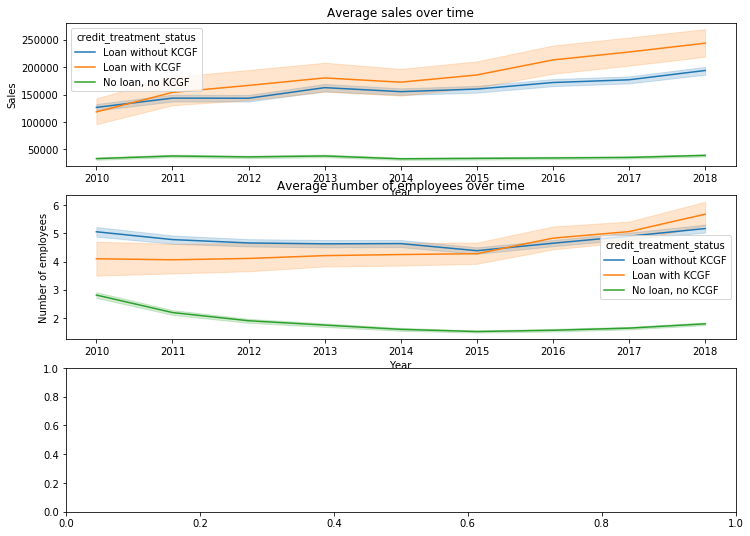

In [15]:
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(12,9))

hue_order = ['Loan without KCGF', 'Loan with KCGF', 'No loan, no KCGF']

sns.lineplot(data=df_master, x='period', y='turnover_tx_r', hue='credit_treatment_status', ax=axes[0],
             hue_order=hue_order)
axes[0].set_xlabel("Year")
axes[0].set_ylabel('Sales')
axes[0].set_title('Average sales over time')


sns.lineplot(data=df_master, x='period', y='employees_tx', hue='credit_treatment_status', ax=axes[1],
             hue_order=hue_order)
axes[1].set_xlabel("Year")
axes[1].set_ylabel('Number of employees')
axes[1].set_title('Average number of employees over time')


sns.lineplot(data=death_rates, x='period', y='death_rates', hue='credit_treatment_status', ax=axes[2],
             hue_order=hue_order)
axes[2].set_xlabel("Year")
axes[2].set_ylabel('Firm exit rate')
#axes[3].set(ylim=(0, 1000))
axes[2].set_title('Firm exit rate over time')

plt.tight_layout()

# entry rates
#sns.lineplot(data=entry_rates, x='period', y='entry_rates', hue='participation_label', ax=axes[3],
#            hue_order=hue_order)
#axes[3].set_xlabel("Year")
#axes[3].set_ylabel('entry rate')
#axes[3].set_title('Firm entry rate over time')
#plt.tight_layout()

plt.savefig(f'../../data/output/graphs/time_series_plots/time_series_plot_1.png')
plt.show()

## fraction of exporting firms & Serbian majority municipality firms

In [18]:
df_master[[x for x in df_master.columns if 'serb' in x]]

""
0
1
2
3
4
...
337106
337107
337108
337109


ValueError: Could not interpret value `Exporting firm` for parameter `y`

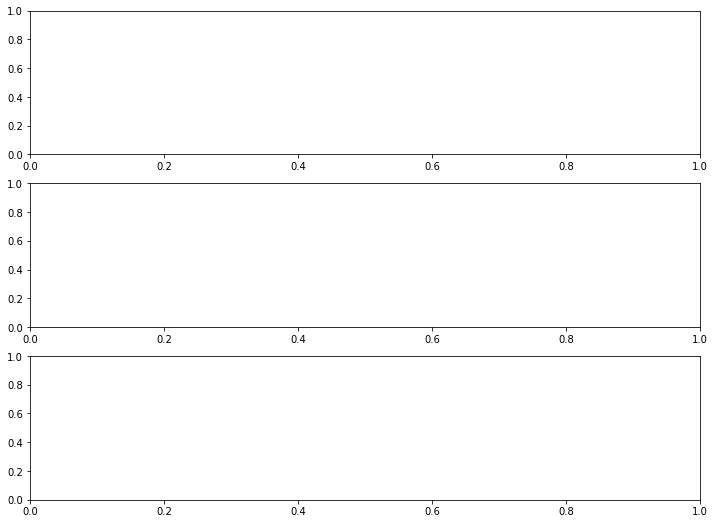

In [14]:
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(12,9))

hue_order = ['not funded by KCGF', 'funded by KCGF', 'no loan received']

sns.lineplot(data=df_master, x='period', y='export_tx', hue='credit_treatment_status', ax=axes[0],
            hue_order=hue_order)
axes[0].set_xlabel("Year")
axes[0].set_ylabel('Export rate')
axes[0].set_title('Fraction of exporting firms')
plt.tight_layout()

sns.lineplot(data=df_master, x='period', y='Serbian-majority municipality', hue='credit_treatment_status', ax=axes[1],
            hue_order=hue_order)
axes[1].set_xlabel("Year")
axes[1].set_ylabel('Serbian majority municipality')
axes[1].set_title('Fraction of Firms belonging to Serbian majority municipality')
plt.tight_layout()

sns.lineplot(data=df_master, x='period', y='age_bis_bis', hue='credit_treatment_status', ax=axes[2],
            hue_order=hue_order)
axes[2].set_xlabel("Year")
axes[2].set_ylabel('Age')
axes[2].set_title('Average firm age over time')
plt.tight_layout()

plt.savefig(f'../../data/output/graphs/time_series_plots/time_series_plot_2.png')
plt.show()

# Include dead firms

In [18]:
dead_panel = pd.read_parquet('../../data/output/firm_year_level_dead.pq', engine='pyarrow')
#dead_panel['kcgf_label'] = dead_panel.kcgf.map({0: 'not funded by KCGF', 1: 'funded by KCGF'})

#dead_panel['kcgf'] = dead_panel.apply(fund_identifier, axis=1)
dead_panel['kcgf_label'] = dead_panel.kcgf.map({0: 'not funded by KCGF', 1: 'funded by KCGF', 2: 'no loan received'})

In [19]:
dead_panel.credit.value_counts()

0.0    140266
1.0     13774
Name: credit, dtype: int64

In [20]:
#dead_panel.groupby(['period', 'kcgf_label']).fuid.size()

In [21]:
#df_master_incl_exit

In [22]:
df_master_incl_exit = pd.concat([df_master[dead_panel.columns], dead_panel]).reset_index()

In [23]:
df_master_incl_exit = df_master_incl_exit.rename(columns={'turnover_tx_r': 'Sales including dead firms',
                                   'Productivity': 'Productivity including dead firms',
                                   'Number of employees': 'Number of employees including dead firms'})

In [24]:
df_master = df_master.rename(columns={'turnover_tx_r': 'Sales'})

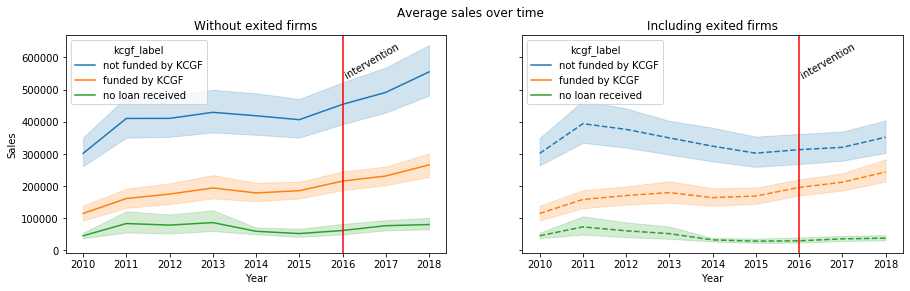

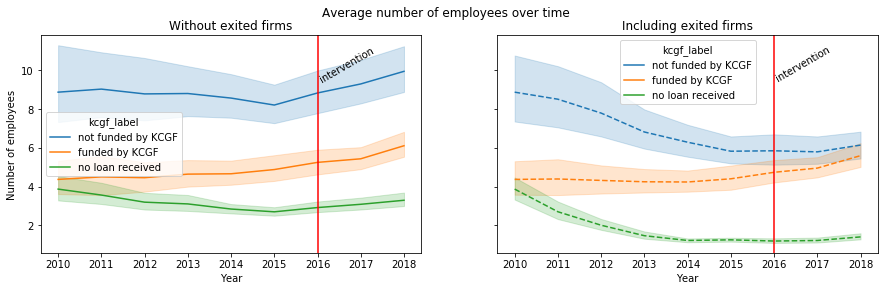

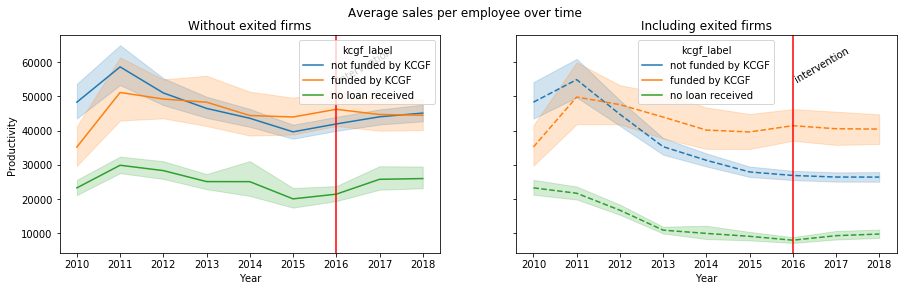

In [26]:
def plot_time_series(variable):

    hue_order = ['not funded by KCGF', 'funded by KCGF', 'no loan received']

    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,4))

    sns.lineplot(data=df_master, x='period', y=variable, hue='kcgf_label', 
                 hue_order=hue_order, ax=axes[0])

    ylim = axes[0].get_ylim()[1]
    axes[0].axvline(2016, 0, ylim, c='red')
    axes[0].text(2016, 0.8*ylim, 'intervention', rotation=30)

    axes[0].set_xlabel("Year")
    axes[0].set_ylabel(variable)
    axes[0].set_title('Without exited firms')


    sns.lineplot(data=df_master_incl_exit, x='period', y=f'{variable} including dead firms', hue='kcgf_label', 
                 hue_order=hue_order, ax=axes[1], linestyle='--')

    ylim = axes[1].get_ylim()[1]
    axes[1].axvline(2016, 0, ylim, c='red')
    axes[1].text(2016, 0.8*ylim, 'intervention', rotation=30)

    axes[1].set_xlabel("Year")
    axes[1].set_ylabel(variable)
    axes[1].set_title('Including exited firms')

    if variable == 'Sales':
        plt.suptitle('Average sales over time')
    elif variable == 'Number of employees':
        plt.suptitle('Average number of employees over time')
    elif variable == 'Productivity':
        plt.suptitle('Average sales per employee over time')

    file_name = variable.replace(' ', '_')
    plt.savefig(f'../../data/output/graphs/time_series_plots/{file_name}.png')

plot_time_series('Sales')
plot_time_series('Number of employees')
plot_time_series('Productivity')

In [23]:
#df_master[[x for x in df_master.columns if 'exit' in x]]

# Interest rate changes

In [24]:
#import random
#fuid_list = random.sample(df_master.fuid.unique().tolist(), 500)
#sns.lineplot(data=df_master[df_master.participation==1].loc[df_master.fuid.isin(fuid_list)], x='period', y='irate_effec', hue='fuid')
#plt.show()
#
#is_rate = df_master[(df_master.participation==1) & ~(df_master.irate_nominal.isna())].shape[0]
#total_participators = df_master[df_master.participation==1].shape[0]
#ratio = round(is_rate/total_participators, 2)
#print(f'Fraction of participator observations where we have interest rate: {ratio}')

In [25]:
#df_master_incl_exit

In [26]:
#inc = df_master_incl_exit.groupby(['period', 'kcgf_label'])[['Number of employees including dead firms',
#       'Sales including dead firms', 'Productivity including dead firms']].mean()

In [27]:
#not_inc = df_master.groupby(['period', 'kcgf_label'])[['Number of employees',
#       'Sales', 'Productivity']].mean()

In [28]:
#inc['Number of employees including dead firms'] - not_inc['Number of employees']

In [83]:
#df_master[['fuid', 'period', 'fund', 'credit', 'kcgf']]

In [37]:
def find_earlier_loans(row):
    if row.period < row.fund_year:
        return 1
    else:
        return 0
    
df_master['earlier_loan'] = df_master.apply(find_earlier_loans, axis=1)

In [48]:
#df_master['earlier_loan'].value_counts(dropna=False)

In [51]:
#df_master[df_master['kcgf']==1].earlier_loan.mean()

/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


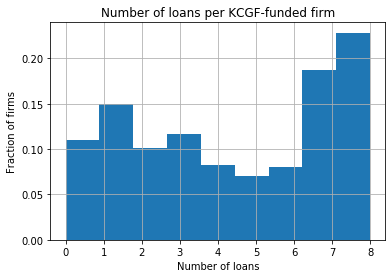

In [82]:
df_master[df_master['kcgf']==1].groupby('fuid').earlier_loan.sum().hist(normed=True, bins=9)
plt.xlabel('Number of loans')
plt.ylabel('Fraction of firms')
plt.title('Number of loans per KCGF-funded firm')
plt.show()

In [64]:
df_master[df_master['kcgf']==1].groupby('fuid').earlier_loan.sum().median()

5.0